<a href="https://colab.research.google.com/github/MuhammadaliMS/Stock_Market_Prediction/blob/master/Stock_Market_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Forecasting with a CNN

## Setup

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
keras = tf.keras
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
#include the google spreadsheet link for the data 
gc = gspread.authorize(GoogleCredentials.get_application_default())
wb = gc.open_by_url('https://docs.google.com/spreadsheets/d/1DA-iyFHPxsL0uz5y59zHXoVT0MtMUfUpPdZ88_JIsm8/edit#gid=1397218343')
#20MICRONS is the ticker data for the stock
sheet = wb.worksheet('20MICRONS')
data = sheet.get_all_values()
df = pd.DataFrame(data)
df.columns = df.iloc[0]
df = df.iloc[1:]
df.head()
(df.High.values)

array(['23.95', '24.08', '23.88', ..., '27.95', '29', '27.8'],
      dtype=object)

In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

# this function creates the X and Y for model training 
def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=2000):
    series = tf.expand_dims(series, axis=-1) 
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)
  
# prepares the input data for forecast
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

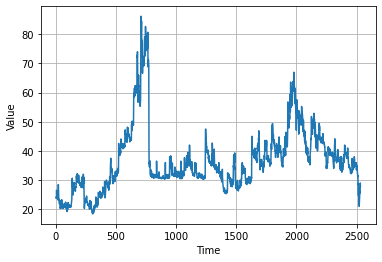

In [3]:
#the data from google sheets comes as strings. So converting to float below
time= df.Date.astype(float)
series = df.High.values.astype(float)
plot_series(time, series)

# Splitting training and validation data 

In [4]:
split_time = 2000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
x_train

array([23.95, 24.08, 23.88, ..., 48.55, 47.1 , 49.9 ])

## Preprocessing With 1D-Convolutional Layers

In [5]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
train_set


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>

## Fully Convolutional Forecasting for optimizing the learning rate

In [6]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
#
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
#creating a callback for optmizing learning rate
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30))
optimizer = keras.optimizers.Adam(lr=1e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
16/16 [==============================] - 0s 28ms/step - loss: 34.8762 - mae: 35.3762 - lr: 1.0000e-04
Epoch 2/100
16/16 [==============================] - 0s 13ms/step - loss: 34.2746 - mae: 34.7746 - lr: 1.0798e-04
Epoch 3/100
16/16 [==============================] - 0s 14ms/step - loss: 33.5014 - mae: 34.0014 - lr: 1.1659e-04
Epoch 4/100
16/16 [==============================] - 0s 13ms/step - loss: 32.2195 - mae: 32.7195 - lr: 1.2589e-04
Epoch 5/100
16/16 [==============================] - 0s 13ms/step - loss: 29.4685 - mae: 29.9685 - lr: 1.3594e-04
Epoch 6/100
16/16 [==============================] - 0s 15ms/step - loss: 23.2009 - mae: 23.7008 - lr: 1.4678e-04
Epoch 7/100
16/16 [==============================] - 0s 14ms/step - loss: 14.9406 - mae: 15.4329 - lr: 1.5849e-04
Epoch 8/100
16/16 [==============================] - 0s 15ms/step - loss: 12.9853 - mae: 13.4789 - lr: 1.7113e-04
Epoch 9/100
16/16 [==============================] - 0s 14ms/step - loss: 10.7579 - mae:

(0.0001, 0.1, 0.0, 30.0)

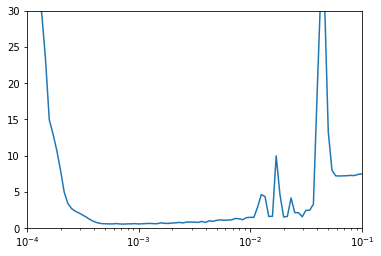

In [7]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, 30])

Wavenet like model

In [8]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
# the learning rate is set 0.001 base on the above calculation. This is specific for this data
optimizer = keras.optimizers.Adam(lr=1e-3)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
# saving the best model 
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
history = model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
16/16 [==============================] - 1s 74ms/step - loss: 26.6284 - mae: 27.1274 - val_loss: 16.7646 - val_mae: 17.2598
Epoch 2/500
16/16 [==============================] - 0s 29ms/step - loss: 13.3314 - mae: 13.8247 - val_loss: 12.0371 - val_mae: 12.5257
Epoch 3/500
16/16 [==============================] - 0s 29ms/step - loss: 7.3446 - mae: 7.8242 - val_loss: 3.8478 - val_mae: 4.3097
Epoch 4/500
16/16 [==============================] - 0s 29ms/step - loss: 2.9094 - mae: 3.3604 - val_loss: 1.9099 - val_mae: 2.3540
Epoch 5/500
16/16 [==============================] - 0s 29ms/step - loss: 1.4939 - mae: 1.9135 - val_loss: 1.2197 - val_mae: 1.6578
Epoch 6/500
16/16 [==============================] - 0s 30ms/step - loss: 1.0170 - mae: 1.4104 - val_loss: 0.8037 - val_mae: 1.1920
Epoch 7/500
16/16 [==============================] - 0s 29ms/step - loss: 0.8009 - mae: 1.1703 - val_loss: 0.7069 - val_mae: 1.0840
Epoch 8/500
16/16 [==============================] - 0s 30ms/step - 

In [9]:
model = keras.models.load_model("my_checkpoint.h5")

In [10]:
cnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
cnn_forecast = cnn_forecast[split_time - window_size:-1, -1, 0]

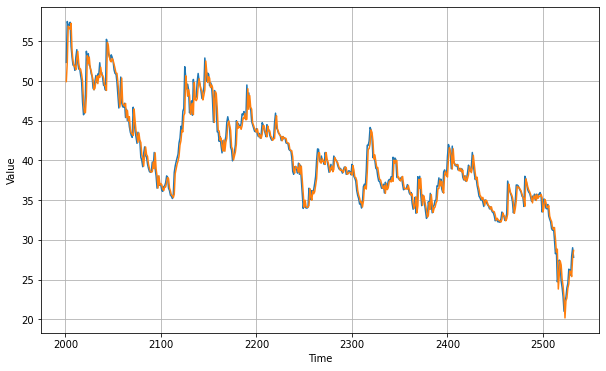

In [11]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, cnn_forecast)

In [12]:
keras.metrics.mean_absolute_error(x_valid, cnn_forecast).numpy()

0.8573959